In [1]:
!git clone https://{clasic_access_token}/big-data-lab-umbc/multivariate-weather-data-clustering.git

Cloning into 'multivariate-weather-data-clustering'...
remote: Enumerating objects: 1153, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 1153 (delta 135), reused 181 (delta 92), pack-reused 903
Receiving objects: 100% (1153/1153), 125.08 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (688/688), done.
Checking out files: 100% (72/72), done.


In [ ]:
 %cd multivariate-weather-data-clustering
 !python setup.py install

In [104]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime as dt
from netCDF4 import date2num,num2date
import cftime
from math import sqrt
import matplotlib.pyplot as plt 
import sys
import seaborn as sns
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D


from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, davies_bouldin_score

from mwdc.preprocessing import preprocessing
from mwdc.evaluation import st_evaluation
from mwdc.visualization import visualization

import dask.dataframe

#### Reading .nc Data

In [4]:
path = ('./data/ERA5_meteo_sfc_2021_daily.nc')
data = xr.open_dataset(path, decode_times=False) 
data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

## Preprocessing 

#### Transforming data
- This function is used to transform the xarray dataset into a pandas dataframe where the dimension "time" would become the index of the DataFrame and, pairs of both dimensions "latitude" and "longitude" will become the columns for each variable

#### Preprocessing Real data

In [5]:
tf_data = preprocessing.datatransformation(data)


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


In [6]:
tf_data = preprocessing.datatransformation(data)

tf_data

sp(43.0,-33.0)  sp(42.75,-33.0)  sp(42.5,-33.0)  sp(42.25,-33.0)  \
0.0     102443.676498    102431.303226   102417.453815    102405.135686   
1.0     101345.768122    101317.220943   101287.358812    101259.804210   
2.0     100624.067447    100584.979445   100543.863872    100504.640134   
3.0     100114.540603    100040.682731    99966.880003     99897.586286   
4.0     100697.759889    100618.637969   100538.930682    100461.853300   
...               ...              ...             ...              ...   
360.0    98843.817016     98872.778201    98904.362934     98940.904619   
361.0    98579.721408     98638.305796    98693.424812     98748.838058   
362.0    98894.706481     98944.369990    98993.923163     99046.639304   
363.0    98648.542535     98667.708326    98687.585171     98714.294683   
364.0    99352.016962     99374.263991    99394.267519     99417.924398   

       sp(42.0,-33.0)  sp(41.75,-33.0)  sp(41.5,-33.0)  sp(41.25,-33.0)  \
0.0     102391.629859    102376.995718   102354.929979    102331.617157   
1.0     101229.348230    101197.229473   101161.144651    101128.482946   
2.0     100464.109927    100422.816199   100374.396282    100326.188453   
3.0      99832.547075     99775.380607    99718.328667     99667.461243   
4.0     100384.593521    100308.381461   100226.426032    100147.134440   
...               ...              ...             ...              ...   
360.0    98979.865525     99023.685306    99065.608941     99111.557801   
361.0    98802.518619     98855.263365    98898.519207     98940.773850   
362.0    99101.378273     99158.916511    99210.345398     99260.842557   
363.0    98744.252980     98774.538199    98798.971517     98822.415897   
364.0    99442.226948     99467.685983    99488.429172     99510.095914   

       sp(41.0,-33.0)  sp(40.75,-33.0)  ...  t2m(35.25,-23.0)  \
0.0     102306.463402    102286.930005  ...        290.000848   
1.0     101095.235875    101068.601739  ...        290.632579   
2.0     100276.279671    100234.684777  ...        290.797767   
3.0      99619.999967     99586.044519  ...        290.893986   
4.0     100068.479115     99995.435665  ...        290.343238   
...               ...              ...  ...               ...   
360.0    99163.068418     99225.224426  ...        292.431912   
361.0    98981.140520     99028.262212  ...        292.397667   
362.0    99311.495004     99370.504390  ...        292.438388   
363.0    98845.627345     98877.167126  ...        292.060683   
364.0    99533.188853     99563.850032  ...        292.161647   

       t2m(35.0,-23.0)  t2m(34.75,-23.0)  t2m(34.5,-23.0)  t2m(34.25,-23.0)  \
0.0         290.122430        290.264916       290.442410        290.577520   
1.0         290.666912        290.741103       290.869634        290.979348   
2.0         290.884106        290.933596       290.999557        291.061465   
3.0         290.875573        290.855689       290.940658        291.090622   
4.0         290.741350        290.962192       291.019160        291.073186   
...                ...               ...              ...               ...   
360.0       292.528418        292.677360       292.888889        293.059160   
361.0       292.426311        292.512561       292.647280        292.745454   
362.0       292.575405        292.739702       292.944218        293.099881   
363.0       292.187234        292.369033       292.632800        292.846336   
364.0       292.251898        292.404644       292.608810        292.749538   

       t2m(34.0,-23.0)  t2m(33.75,-23.0)  t2m(33.5,-23.0)  t2m(33.25,-23.0)  \
0.0         290.716088        290.867770       291.004767        291.069088   
1.0         291.094496        291.188648       291.258157        291.281510   
2.0         291.153361        291.255193       291.347718        291.426658   
3.0         291.246660        291.372272       291.492091        291.587344   
4.0         291.165834        291.315630       291.485410        291.615917   
.

In [7]:
non_norm_tf_data = tf_data
# Normalizing data
tf_data = preprocessing.datanormalization(tf_data)


In [8]:
tf_data

sp(43.0,-33.0)  sp(42.75,-33.0)  sp(42.5,-33.0)  sp(42.25,-33.0)  \
0.0          0.769017         0.763551        0.758399         0.754214   
1.0          0.550508         0.539280        0.528615         0.520168   
2.0          0.406872         0.391876        0.377439         0.365852   
3.0          0.305465         0.282306        0.260121         0.241803   
4.0          0.421539         0.398652        0.376436         0.357109   
...               ...              ...             ...              ...   
360.0        0.052561         0.047201        0.044078         0.046307   
361.0        0.000000         0.000000        0.001187         0.007059   
362.0        0.062689         0.061612        0.062288         0.067914   
363.0        0.013697         0.005919        0.000000         0.000000   
364.0        0.153705         0.148152        0.143691         0.143785   

       sp(42.0,-33.0)  sp(41.75,-33.0)  sp(41.5,-33.0)  sp(41.25,-33.0)  \
0.0          0.749653         0.744597        0.739195         0.733298   
1.0          0.510767         0.500749        0.491037         0.481886   
2.0          0.353486         0.340685        0.327491         0.314235   
3.0          0.223679         0.206865        0.191111         0.176584   
4.0          0.337143         0.317032        0.296732         0.276819   
...               ...              ...             ...              ...   
360.0        0.048426         0.051497        0.055427         0.060420   
361.0        0.011975         0.016685        0.020693         0.024733   
362.0        0.073401         0.079448        0.085514         0.091616   
363.0        0.000000         0.000000        0.000000         0.000000   
364.0        0.143456         0.143268        0.143321         0.143701   

       sp(41.0,-33.0)  sp(40.75,-33.0)  ...  t2m(35.25,-23.0)  \
0.0          0.726633         0.719377  ...          0.307300   
1.0          0.472325         0.462340  ...          0.366677   
2.0          0.300378         0.286403  ...          0.382203   
3.0          0.162586         0.149556  ...          0.391246   
4.0          0.256749         0.235928  ...          0.339481   
...               ...              ...  ...               ...   
360.0        0.066650         0.073432  ...          0.535796   
361.0        0.028452         0.031877  ...          0.532577   
362.0        0.097813         0.104082  ...          0.536404   
363.0        0.000000         0.000000  ...          0.500904   
364.0        0.144360         0.144873  ...          0.510393   

       t2m(35.0,-23.0)  t2m(34.75,-23.0)  t2m(34.5,-23.0)  t2m(34.25,-23.0)  \
0.0           0.312956          0.318721         0.328563          0.334153   
1.0           0.364151          0.363580         0.368759          0.371705   
2.0           0.384572          0.381714         0.380983          0.379379   
3.0           0.383770          0.374375         0.375442          0.382104   
4.0           0.371150          0.384408         0.382828          0.380475   
...                ...               ...              ...               ...   
360.0         0.539179          0.545987         0.558745          0.566072   
361.0         0.529579          0.530462         0.536012          0.536755   
362.0         0.543597          0.551860         0.563950          0.569878   
363.0         0.507099          0.516941         0.534650          0.546183   
364.0         0.513179          0.520296         0.532393          0.537137   

       t2m(34.0,-23.0)  t2m(33.75,-23.0)  t2m(33.5,-23.0)  t2m(33.25,-23.0)  \
0.0           0.337154          0.340863         0.343122          0.338263   
1.0           0.372464          0.370914         0.367119          0.358756   
2.0           0.377956          0.377146         0.375601          0.372759   
3.0           0.386662          0.388110         0.389274          0.388262   
4.0           0.379120          0.382806         0.388641          0.391018   
.

#### Preprocessing single variable (SST)

In [9]:
data_single_var = data
data_single_var = data_single_var.drop('t2m')
data_single_var = data_single_var.drop('slhf')
data_single_var = data_single_var.drop('sshf')
data_single_var = data_single_var.drop('v10')
data_single_var = data_single_var.drop('u10')
data_single_var = data_single_var.drop('sp')

data_single_var

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sst        (time, latitude, longitude) float64 290.1 290.0 ... 293.4 293.3
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

In [117]:
data_single_var.to_netcdf('./data/single_var_ERA5_meteo_sfc_2021_daily.nc')

In [10]:
tf_sst_data = preprocessing.datatransformation(data_single_var)
tf_sst_data

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


sst(43.0,-33.0)  sst(42.75,-33.0)  sst(42.5,-33.0)  sst(42.25,-33.0)  \
0.0         290.120809        290.198989       290.163838        289.908009   
1.0         290.079384        290.077223       290.026065        289.839130   
2.0         289.852013        289.914604       289.911355        289.774294   
3.0         289.723889        289.820934       289.819498        289.687540   
4.0         289.885672        290.112513       290.180598        290.013991   
...                ...               ...              ...               ...   
360.0       289.489953        289.579523       289.676942        289.729824   
361.0       289.552235        289.658312       289.777707        289.838365   
362.0       289.467150        289.556451       289.710454        289.841128   
363.0       289.414596        289.608265       289.756557        289.809126   
364.0       289.446257        289.557035       289.672441        289.703546   

       sst(42.0,-33.0)  sst(41.75,-33.0)  sst(41.5,-33.0)  sst(41.25,-33.0)  \
0.0         289.776023        289.416485       289.279786        289.298749   
1.0         289.695864        289.328392       289.194537        289.201049   
2.0         289.640830        289.323623       289.225770        289.269552   
3.0         289.494497        289.156347       289.109373        289.139239   
4.0         289.699503        289.233230       289.169244        289.194356   
...                ...               ...              ...               ...   
360.0       289.775556        289.700285       289.696682        289.980434   
361.0       289.739096        289.638772       289.630882        289.779872   
362.0       289.798871        289.689019       289.597269        289.627577   
363.0       289.658526        289.645622       289.583041        289.649582   
364.0       289.687196        289.621510       289.526413        289.513125   

       sst(41.0,-33.0)  sst(40.75,-33.0)  ...  sst(35.25,-23.0)  \
0.0         289.412232        289.612776  ...        292.574080   
1.0         289.294831        289.487051  ...        292.453081   
2.0         289.370277        289.552165  ...        292.283477   
3.0         289.313556        289.628588  ...        292.221876   
4.0         289.440634        289.745181  ...        292.065796   
...                ...               ...  ...               ...   
360.0       290.145347        290.183858  ...        292.046897   
361.0       289.968499        290.342562  ...        292.012217   
362.0       289.851696        290.304705  ...        291.997647   
363.0       289.875481        290.261779  ...        291.896725   
364.0       289.712063        290.197261  ...        291.842590   

       sst(35.0,-23.0)  sst(34.75,-23.0)  sst(34.5,-23.0)  sst(34.25,-23.0)  \
0.0         292.498104        292.416313       292.350892        292.321388   
1.0         292.446389        292.388831       292.292610        292.249929   
2.0         292.329824        292.275278       292.176198        292.131204   
3.0         292.467317        292.448424       292.259843        292.151310   
4.0         292.313719        292.325013       292.150905        292.053275   
...                ...               ...              ...               ...   
360.0       292.095863        292.210913       292.492743        292.851638   
361.0       291.971526        292.138619       292.510788        292.859457   
362.0       292.015336        292.195190       292.554042        292.955437   
363.0       291.912264        292.118893       292.544243        292.924730   
364.0       291.798239        292.029707       292.431016        292.823979   

       sst(34.0,-23.0)  sst(33.75,-23.0)  sst(33.5,-23.0)  sst(33.25,-23.0)  \
0.0         292.353764        292.406358       292.468126        292.535987   
1.0         292.284439        292.348647       292.434885        292.529030   
2.0         292.163175        292.246123       292.350501        292.443391   
3.0         292.011446        292.08368

In [11]:
# Normalizing data
tf_sst_data = preprocessing.datanormalization(tf_sst_data)
tf_sst_data

sst(43.0,-33.0)  sst(42.75,-33.0)  sst(42.5,-33.0)  sst(42.25,-33.0)  \
0.0           0.277382          0.278881         0.258121          0.238704   
1.0           0.271699          0.262313         0.240006          0.230049   
2.0           0.240507          0.240187         0.224924          0.221902   
3.0           0.222930          0.227442         0.212846          0.211001   
4.0           0.245124          0.267115         0.260324          0.252021   
...                ...               ...              ...               ...   
360.0         0.190837          0.194594         0.194103          0.216314   
361.0         0.199381          0.205315         0.207352          0.229953   
362.0         0.187708          0.191455         0.198509          0.230300   
363.0         0.180499          0.198505         0.204571          0.226279   
364.0         0.184842          0.191535         0.193511          0.213012   

       sst(42.0,-33.0)  sst(41.75,-33.0)  sst(41.5,-33.0)  sst(41.25,-33.0)  \
0.0           0.203745          0.166139         0.140511          0.154529   
1.0           0.193627          0.155130         0.129881          0.142990   
2.0           0.186680          0.154535         0.133776          0.151081   
3.0           0.168209          0.133631         0.119261          0.135690   
4.0           0.194086          0.143239         0.126727          0.142200   
...                ...               ...              ...               ...   
360.0         0.203687          0.201603         0.192497          0.235040   
361.0         0.199084          0.193916         0.184292          0.211353   
362.0         0.206630          0.200195         0.180101          0.193366   
363.0         0.188914          0.194772         0.178327          0.195965   
364.0         0.192533          0.191759         0.171265          0.179848   

       sst(41.0,-33.0)  sst(40.75,-33.0)  ...  sst(35.25,-23.0)  \
0.0           0.145160          0.146470  ...          0.323063   
1.0           0.131470          0.131819  ...          0.308363   
2.0           0.140268          0.139407  ...          0.287759   
3.0           0.133653          0.148313  ...          0.280275   
4.0           0.148472          0.161899  ...          0.261313   
...                ...               ...  ...               ...   
360.0         0.230651          0.213018  ...          0.259017   
361.0         0.210028          0.231512  ...          0.254804   
362.0         0.196408          0.227100  ...          0.253034   
363.0         0.199181          0.222098  ...          0.240773   
364.0         0.180125          0.214580  ...          0.234196   

       sst(35.0,-23.0)  sst(34.75,-23.0)  sst(34.5,-23.0)  sst(34.25,-23.0)  \
0.0           0.297638          0.266496         0.220348          0.182856   
1.0           0.291336          0.263035         0.212799          0.173478   
2.0           0.277129          0.248735         0.197720          0.157897   
3.0           0.293886          0.270540         0.208555          0.160535   
4.0           0.275167          0.254999         0.194444          0.147670   
...                ...               ...              ...               ...   
360.0         0.248616          0.240630         0.238721          0.252444   
361.0         0.233462          0.231525         0.241058          0.253470   
362.0         0.238802          0.238649         0.246661          0.266066   
363.0         0.226240          0.229041         0.245392          0.262036   
364.0         0.212343          0.217810         0.230726          0.248814   

       sst(34.0,-23.0)  sst(33.75,-23.0)  sst(33.5,-23.0)  sst(33.25,-23.0)  \
0.0           0.162071          0.179624         0.188698          0.187435   
1.0           0.152879          0.172126         0.184331          0.186509   
2.0           0.136800          0.158805         0.173245          0.175106   
3.0           0.116681          0.13769

## Dimension Reduction

### KernelPCA

- Kernel PCA is a non-linear dimensionality reduction technique that uses kernels. It can also be considered as the non-linear form of normal PCA.

#### Finding the proper number of components for Kernel PCA

##### Number of components for single variable data

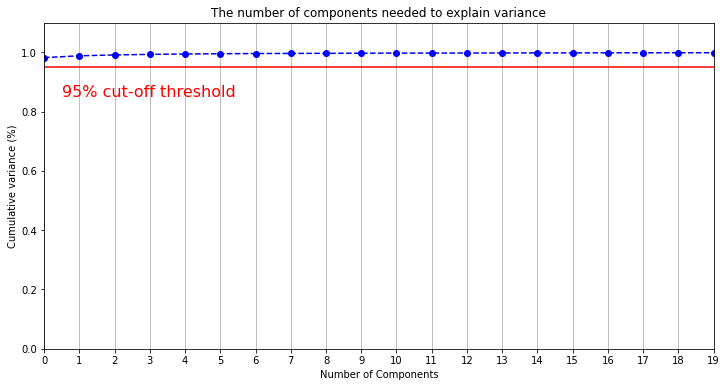

In [12]:
preprocessing.pcacomponents(tf_sst_data)

Based on the plot above the best number of components for single variable data is 2.

##### Number of components for real data

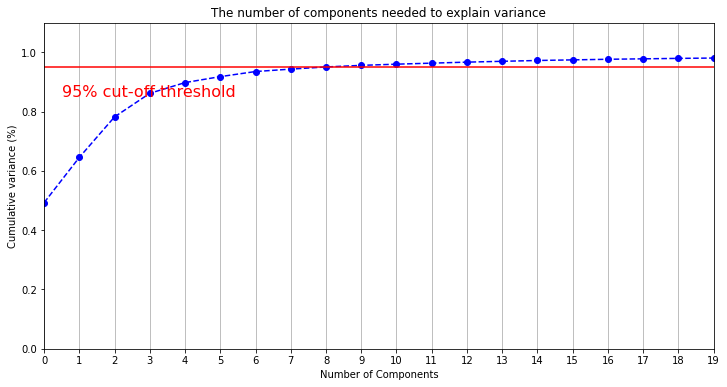

In [13]:
preprocessing.pcacomponents(tf_data)

Based on the plot above the best number of components for real data is 15.

In [ ]:
pca = PCA(n_components = 2)
Single_var_PCA = pca.fit_transform(tf_sst_data)
   


In [ ]:
kpca = KernelPCA(n_components=2, kernel='rbf')
Single_var_kpca = kpca.fit_transform(tf_sst_data)




In [15]:
Single_var_kpca.shape

(365, 2)

#### Applying KernelPCA for real data

In [16]:
kpca = KernelPCA(n_components=15, kernel='rbf')
real_kpca = kpca.fit_transform(tf_data)
real_kpca


array([[ 0.18079048, -0.07575304, -0.05554408, ..., -0.01693787,
         0.01967535, -0.02978596],
       [ 0.18604405,  0.01755846, -0.02514849, ...,  0.00601374,
         0.01831528, -0.02749639],
       [ 0.18978488,  0.11251013,  0.01914892, ...,  0.04029303,
         0.02179862,  0.00064807],
       ...,
       [ 0.17797391,  0.24370379,  0.09322344, ...,  0.03056805,
        -0.00178476,  0.01243627],
       [ 0.19620549,  0.26354036,  0.17241536, ...,  0.03287361,
         0.00750907, -0.03181158],
       [ 0.19917055,  0.20128299,  0.26612819, ...,  0.03885298,
         0.02391195, -0.02284425]])

##### Correlation Heatmap

### t-SNE

- t-distributed Stochastic Neighbor Embedding
- It is recommended in the documentation of [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to lower the demension of data to 50 or less with `KernelPCA` before applying t-SNE.

#### Applying t-SNE to single variable data

In [48]:
kpca = KernelPCA(n_components=50, kernel='rbf')
Single_kpca = kpca.fit_transform(tf_sst_data)
Single_kpca

array([[-3.86829371e-01,  1.65336604e-02, -2.16515023e-02, ...,
         1.25209790e-04, -1.18999062e-03,  5.32770662e-04],
       [-3.88743641e-01,  1.86547485e-02, -2.25250649e-02, ...,
         2.04230352e-03, -1.25030028e-03,  1.61741892e-03],
       [-3.87251306e-01,  1.65931972e-02, -2.20104365e-02, ...,
         1.02319567e-03,  6.08617059e-05,  3.55121542e-04],
       ...,
       [-2.77141364e-01, -6.93386581e-02, -5.63429960e-03, ...,
         3.28854023e-03,  8.95308323e-05, -3.86505668e-04],
       [-2.83699163e-01, -6.46425314e-02, -1.04811853e-02, ...,
         1.73578397e-03, -1.17691307e-03, -1.44792611e-03],
       [-2.86561850e-01, -6.35287605e-02, -8.44378687e-03, ...,
         1.70146300e-03, -4.52424250e-04, -1.84750199e-03]])

In [168]:
tsne = TSNE(n_components=2, learning_rate='auto', perplexity=40)
Single_var_tsne = tsne.fit_transform(Single_kpca)



/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


#### Applying t-SNE to real data

In [79]:
kpca = KernelPCA(n_components=50, kernel='rbf')
real_kpca = kpca.fit_transform(tf_data)
real_kpca

array([[ 0.18079048, -0.07575304, -0.05554408, ...,  0.01124047,
         0.00081747,  0.00855359],
       [ 0.18604405,  0.01755846, -0.02514849, ..., -0.00278301,
         0.00045732,  0.01690047],
       [ 0.18978488,  0.11251013,  0.01914892, ...,  0.02012844,
         0.00050619,  0.01889304],
       ...,
       [ 0.17797391,  0.24370379,  0.09322344, ..., -0.00978058,
         0.0032539 , -0.0003909 ],
       [ 0.19620549,  0.26354036,  0.17241536, ..., -0.00933879,
         0.00628311, -0.01055571],
       [ 0.19917055,  0.20128299,  0.26612819, ..., -0.01432498,
         0.00218311, -0.00498908]])

In [184]:
tsne = TSNE(n_components=2, learning_rate='auto', perplexity=45)
real_tsne = tsne.fit_transform(real_kpca)
real_tsne

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


array([[ 12.245225  ,  -5.0718913 ],
       [ 14.145195  ,  -5.3150277 ],
       [ 15.120091  ,  -5.7879086 ],
       [ 15.420231  ,  -6.25364   ],
       [ 15.426773  ,  -5.830898  ],
       [ 10.938888  ,   2.5399642 ],
       [  9.663546  ,   2.210772  ],
       [  9.206969  ,   1.2341301 ],
       [  9.51954   ,  -2.383205  ],
       [  9.146209  ,  -4.139571  ],
       [  8.650591  ,  -6.7726355 ],
       [  7.8979588 ,  -8.216611  ],
       [  8.276964  ,  -6.1074405 ],
       [  7.8259883 ,  -7.5474505 ],
       [  8.019162  ,  -8.104883  ],
       [  8.264671  ,  -6.472353  ],
       [  7.526922  ,  -8.697636  ],
       [  7.462666  , -11.0454645 ],
       [ 10.571124  , -12.307819  ],
       [  8.267388  , -10.9755535 ],
       [ 10.759966  , -11.446187  ],
       [  6.52906   ,  -8.305901  ],
       [  6.806812  ,  -9.001027  ],
       [  6.5619946 , -10.720113  ],
       [  6.0113454 , -10.419596  ],
       [  5.631014  , -10.761416  ],
       [  7.0992117 , -12.358827  ],
 

# Clustering 

## Applying KMeans for `single variable` data with `KernelPCA`

In [96]:
distortions = []
inertias = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(Single_var_kpca)
    distortions.append(sum(np.min(cdist(Single_var_kpca, km.cluster_centers_,'euclidean'), axis=1)) / Single_var_kpca.shape[0])
    inertias.append(km.inertia_)


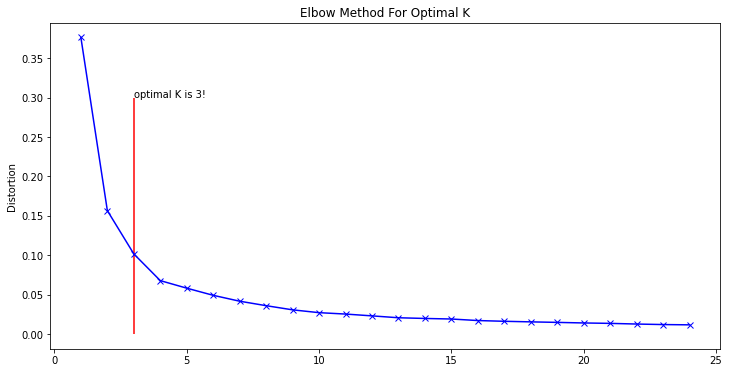

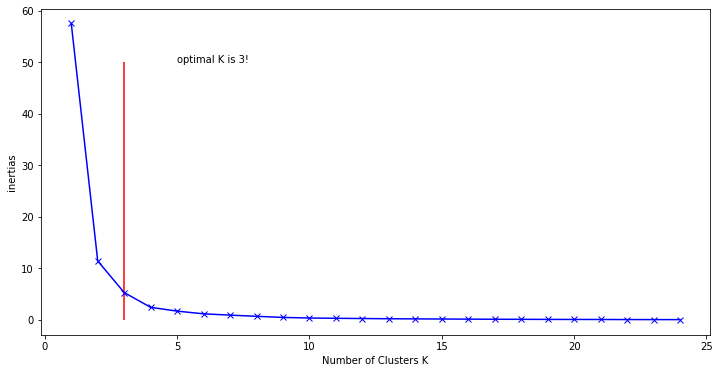

In [35]:
plt.plot(K, distortions, 'bx-')
plt.vlines(ymin=0, ymax=0.3, x=3, colors='red')
plt.text(x=3, y=0.3, s="optimal K is 3!")
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal K')
plt.show()


plt.plot(K, inertias, 'bx-')
plt.vlines(ymin=0, ymax=50, x=3, colors='red')
plt.text(x=5, y=50, s="optimal K is 3!")
plt.xlabel('Number of Clusters K')
plt.ylabel('inertias')
plt.show()

In [78]:
#PCA
kmeans = KMeans(n_clusters=2)
kmeans.fit(Single_var_PCA)
P = kmeans.predict(Single_var_PCA)
PCA_sst_labels =  kmeans.labels_
PCA_sst_frame = pd.DataFrame(Single_var_PCA)
PCA_sst_frame['Cluster'] = PCA_sst_labels
PCA_sst_frame

0         1  Cluster
0   -12.409141 -0.807770        1
1   -12.489201 -0.833298        1
2   -12.430183 -0.775558        1
3   -12.648815 -0.458295        1
4   -12.639061 -0.817500        1
..         ...       ...      ...
360  -8.129978  0.304112        1
361  -8.534610  0.209191        1
362  -8.457739  0.315682        1
363  -8.680229  0.149018        1
364  -8.774477  0.208544        1

[365 rows x 3 columns]

In [42]:
#kernelPCA
kmeans = KMeans(n_clusters=2)
kmeans.fit(Single_var_kpca)
P = kmeans.predict(Single_var_kpca)
kpca_sst_labels =  kmeans.labels_
kpca_sst_frame = pd.DataFrame(Single_var_kpca)
kpca_sst_frame['Cluster'] = kpca_sst_labels
kpca_sst_frame

0         1  Cluster
0   -0.386829  0.016534        1
1   -0.388744  0.018655        1
2   -0.387251  0.016593        1
3   -0.392669  0.020117        1
4   -0.392679  0.021664        1
..        ...       ...      ...
360 -0.267398 -0.074862        1
361 -0.279439 -0.067231        1
362 -0.277141 -0.069339        1
363 -0.283699 -0.064643        1
364 -0.286562 -0.063529        1

[365 rows x 3 columns]

## Applying KMeans for `real` data with `KernelPCA`



In [97]:
distortions = []
inertias = []
K = range(1,70, 3)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(real_kpca)
    distortions.append(sum(np.min(cdist(real_kpca, km.cluster_centers_,'euclidean'), axis=1)) / real_kpca.shape[0])
    inertias.append(km.inertia_)


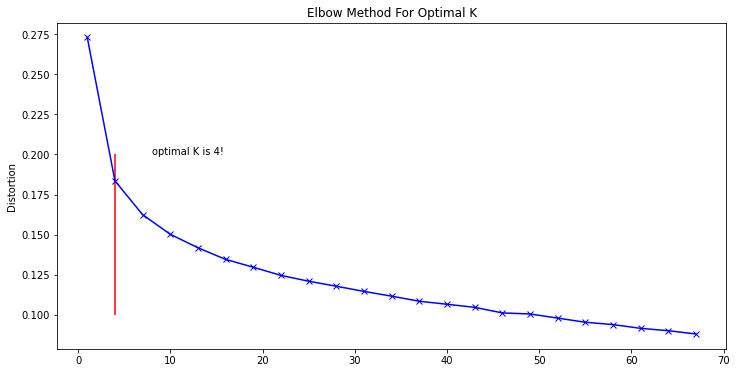

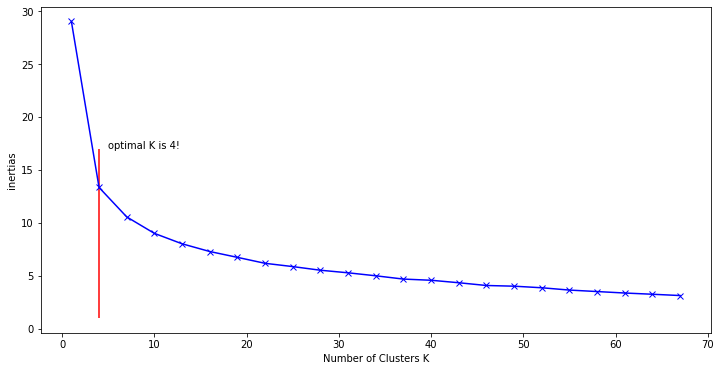

In [98]:
plt.plot(K, distortions, 'bx-')
plt.vlines(ymin=0.1, ymax=0.2, x=4, colors='red')
plt.text(x=8, y=0.2, s="optimal K is 4!")
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal K')
plt.show()


plt.plot(K, inertias, 'bx-')
plt.vlines(ymin=1, ymax=17, x=4, colors='red')
plt.text(x=5, y=17, s="optimal K is 4!")
plt.xlabel('Number of Clusters K')
plt.ylabel('inertias')
plt.show()

In [123]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(real_kpca)
P = kmeans.predict(real_kpca)
kpca_labels =  kmeans.labels_
kpca_frame = pd.DataFrame(real_kpca)
kpca_frame['Cluster'] = kpca_labels
kpca_labels

array([0, 1, 1, 1, 1, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

## Applying KMeans for `single variable` data with `t-SNE`

In [51]:
distortions = []
inertias = []
K = range(1,50, 2)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(Single_var_tsne)
    distortions.append(sum(np.min(cdist(Single_var_tsne, km.cluster_centers_,'euclidean'), axis=1)) / Single_var_tsne.shape[0])
    inertias.append(km.inertia_)

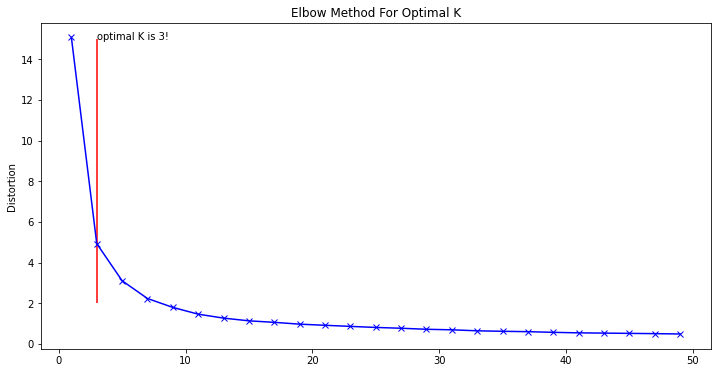

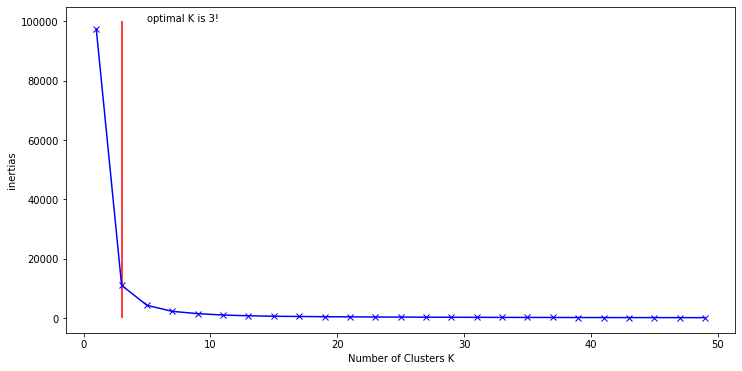

In [57]:
plt.plot(K, distortions, 'bx-')
plt.vlines(ymin=2, ymax=15, x=3, colors='red')
plt.text(x=3, y=15, s="optimal K is 3!")
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal K')
plt.show()


plt.plot(K, inertias, 'bx-')
plt.vlines(ymin=0, ymax=100000, x=3, colors='red')
plt.text(x=5, y=100000, s="optimal K is 3!")
plt.xlabel('Number of Clusters K')
plt.ylabel('inertias')
plt.show()

In [102]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(Single_var_tsne)
P = kmeans.predict(Single_var_tsne)
tsne_sst_labels =  kmeans.labels_
tsne_sst_frame = pd.DataFrame(Single_var_tsne)
tsne_sst_frame['Cluster'] = tsne_sst_labels
tsne_sst_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Applying KMeans for `real` data with `t-SNE`

In [105]:
distortions = []
inertias = []
K = range(1,70, 3)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(real_tsne)
    distortions.append(sum(np.min(cdist(real_tsne, km.cluster_centers_,'euclidean'), axis=1)) / real_tsne.shape[0])
    inertias.append(km.inertia_)

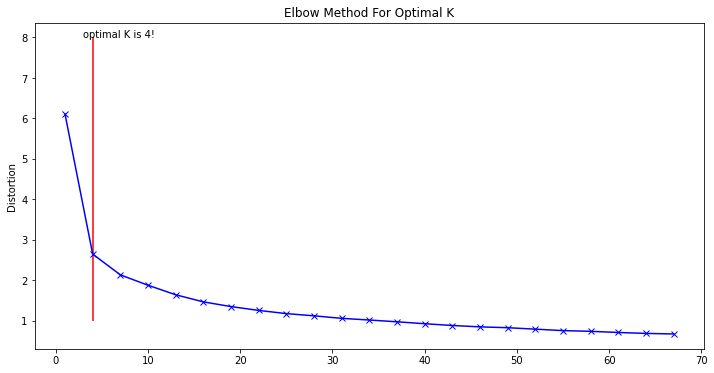

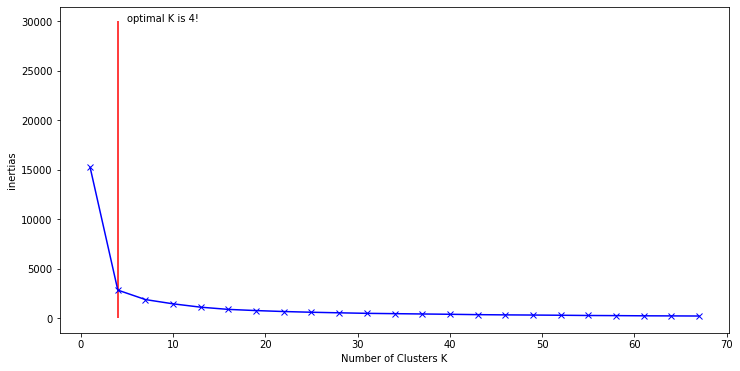

In [106]:
plt.plot(K, distortions, 'bx-')
plt.vlines(ymin=1, ymax=8, x=4, colors='red')
plt.text(x=3, y=8, s="optimal K is 4!")
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal K')
plt.show()


plt.plot(K, inertias, 'bx-')
plt.vlines(ymin=0, ymax=30000, x=4, colors='red')
plt.text(x=5, y=30000, s="optimal K is 4!")
plt.xlabel('Number of Clusters K')
plt.ylabel('inertias')
plt.show()

In [185]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(real_tsne)
P = kmeans.predict(real_tsne)
tsne_labels =  kmeans.labels_
tsne_frame = pd.DataFrame(real_tsne)
tsne_frame['Cluster'] = tsne_labels
tsne_labels

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

# Analyzing dimension reduced data

### Analyzing single variable data

- Scattered the dimension reduced data for single variable (SST) in order presend the behavior of each dimention. reduction technique.

### Comparing PCA and KernelPCA results for single variable data (SST)

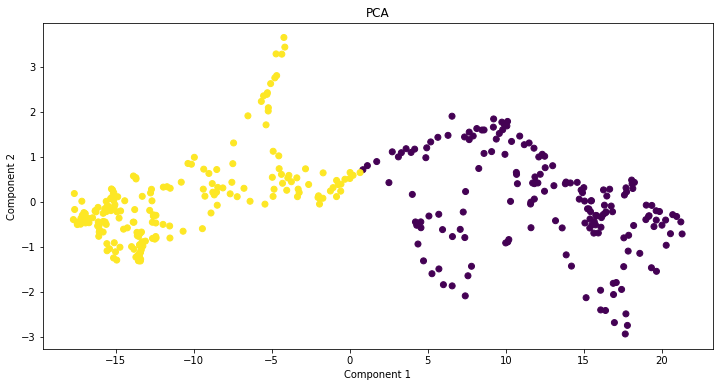

In [130]:
plt.title("PCA")
plt.scatter(Single_var_PCA[:, 0], Single_var_PCA[:, 1], c=PCA_sst_labels)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

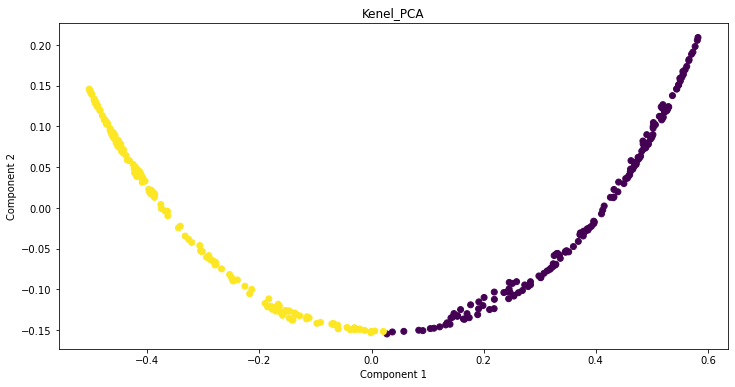

In [131]:
plt.title("Kenel_PCA")
plt.scatter(Single_var_kpca[:, 0], Single_var_kpca[:, 1], c= kpca_sst_labels)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### Applying t-SNE to after reducing the dimension of single variable data with Kpca

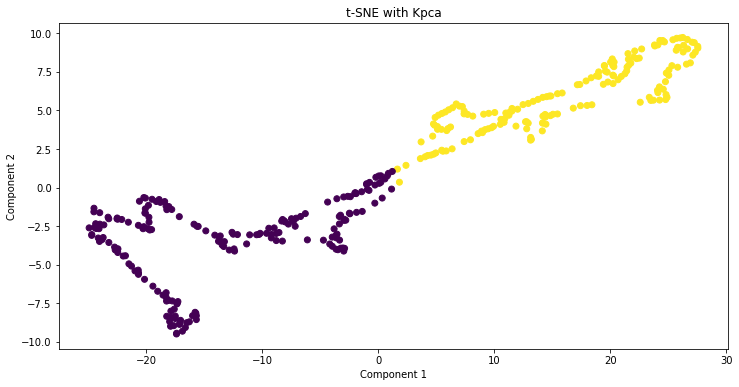

In [132]:
plt.title("t-SNE with Kpca")
plt.scatter(Single_var_tsne[:, 0], Single_var_tsne[:, 1], c= tsne_sst_labels)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### Applying t-SNE directly to transformed single variable data

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


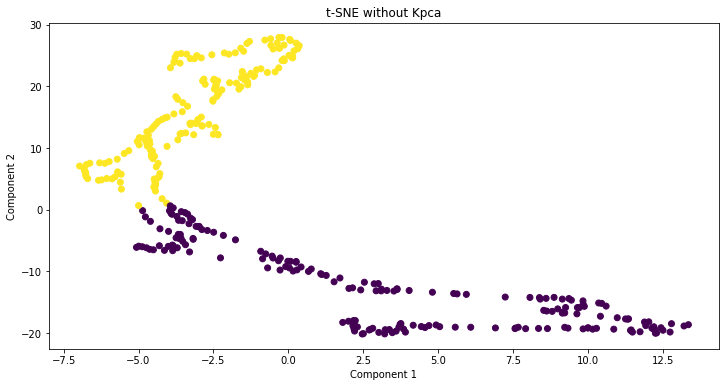

In [144]:
tsne = TSNE(n_components=2, learning_rate='auto', perplexity=40)
Single_var_tsne_no_kpca = tsne.fit_transform(tf_sst_data)

plt.title("t-SNE without Kpca")
plt.scatter(Single_var_tsne_no_kpca[:, 0], Single_var_tsne_no_kpca[:, 1], c= tsne_sst_labels)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## Analyzing real daily data (7 variable) before and after applying dimension reduction techniques

- Computing and ploting the variance of data for each day in order to analyze the dimention reduced data.
- The X axis is the number of days and the Y axis indicates the variance of data in that day.

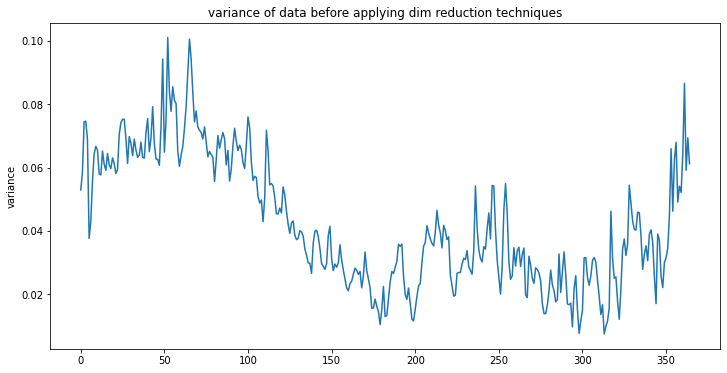

In [153]:
variance_not_dim_reduct =  tf_data.var(axis=1)

plt.plot(range(len(variance_not_dim_reduct)), variance_not_dim_reduct)
plt.ylabel('variance')
plt.title('variance of data before applying dim reduction techniques')
plt.show()


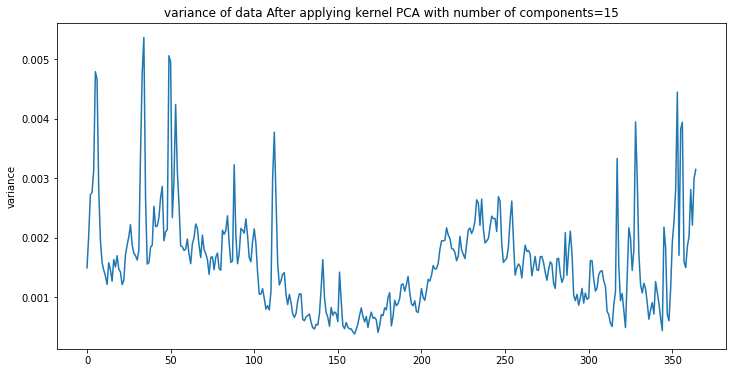

In [155]:
variance_kpca = pd.DataFrame(real_kpca).var(axis=1)

plt.plot(range(len(variance_kpca)), variance_kpca)
plt.ylabel('variance')
plt.title('variance of data After applying kernel PCA with number of components=15')
plt.show()

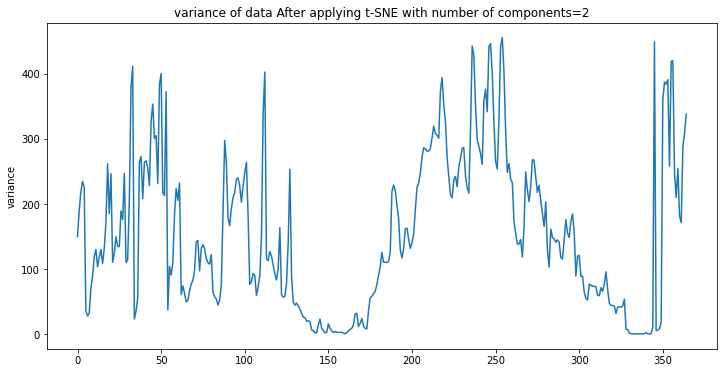

In [192]:
variance_tsne = pd.DataFrame(real_tsne).var(axis=1)

plt.plot(range(len(variance_tsne)), variance_tsne)
plt.ylabel('variance')
plt.title('variance of data After applying t-SNE with number of components=2')
plt.show()

# Evaluation and Visualization

Applying RMSE , Silhouette Coefficient and Davies-Bouldin scores to evaluate the clustering.

##### Silhouette Coefficient score

- The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.

- The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.


##### Davies-Bouldin score

- The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.

- The minimum score is zero, with lower values indicating better clustering.

## - `Single variable` data with `KernelPCA` ( n_features=2  and n_cluster=2 )

In [44]:
print('RMSE is: ')
print( st_evaluation.st_rmse(data_single_var,kpca_sst_labels))


RMSE is: 


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


       0      1
0   5.49  23.32
1  23.32   5.53


In [120]:
print('Spatial Correlation is: ')
print( st_evaluation.st_corr(data_single_var,kpca_sst_labels))


Spatial Correlation is: 


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


          0         1
0      0.63  0.585183
1  0.585183      0.52


In [77]:
print("Silhouette Coefficient score is ", silhouette_score(tf_sst_data, kpca_sst_labels))

print("Davies-Bouldin score is ", davies_bouldin_score(tf_sst_data, kpca_sst_labels))

Silhouette Coefficient score is  0.6876292288723352
Davies-Bouldin score is  0.4253510395368853


In [113]:
visualization.make_Csv_cluster(kpca_sst_labels,'./data/kpca_sst.csv')

total clusters:  2
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/content/multivariate-weather-data-clustering/mwdc/visualization/visualization.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.subplot(panel)
/content/multivariate-weather-data-clustering/mwdc/visualization/visualization.py:74: UserWarning: The following kwargs were not used by contour: 'linewidth'
  p1=ax.contour(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/11),extend = 'both',linewidth=0.6)


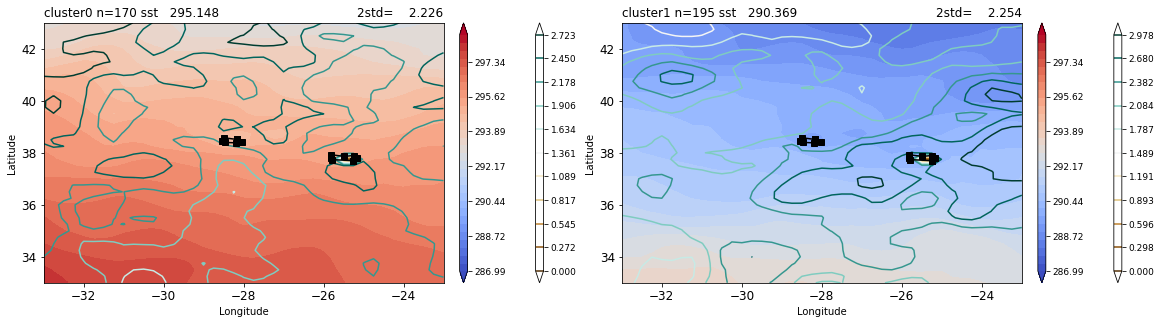

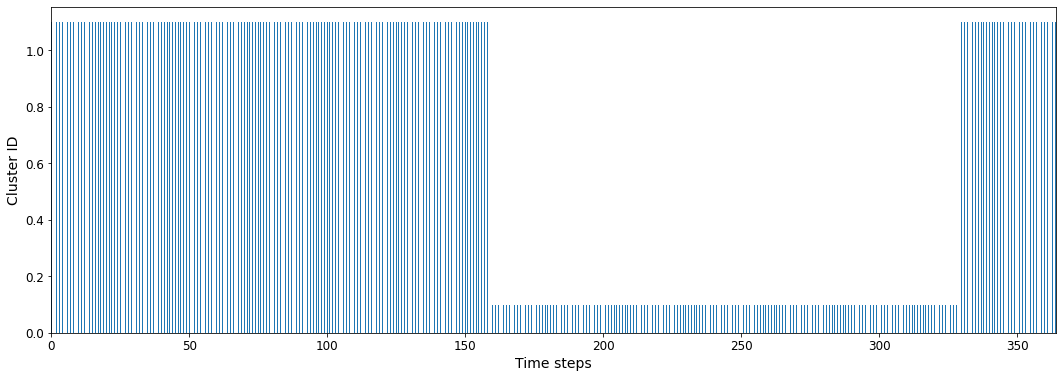

In [118]:
visualization.visualization('./data/single_var_ERA5_meteo_sfc_2021_daily.nc','./data/kpca_sst.csv','./data/coast.txt',['sst'])

## - `Single variable` data with `t-SNE` ( n_features=2  and n_cluster=2 )

In [121]:
print('RMSE is: ')
print( st_evaluation.st_rmse(data_single_var,tsne_sst_labels))


RMSE is: 


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


       0      1
0   5.53  23.32
1  23.32   5.49


In [122]:
print('Spatial Correlation is: ')
print( st_evaluation.st_corr(data_single_var,tsne_sst_labels))

Spatial Correlation is: 


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


          0         1
0      0.52  0.585183
1  0.585183      0.63


In [103]:

print("Silhouette Coefficient score is ", silhouette_score(tf_sst_data, tsne_sst_labels))

print("Davies-Bouldin score is ", davies_bouldin_score(tf_sst_data, tsne_sst_labels))

Silhouette Coefficient score is  0.6876292288723352
Davies-Bouldin score is  0.4253510395368853


In [ ]:
visualization.make_Csv_cluster(tsne_sst_labels,'./data/tsne_sst.csv')

total clusters:  2
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: The following kwargs were not used by contour: 'linewidth'


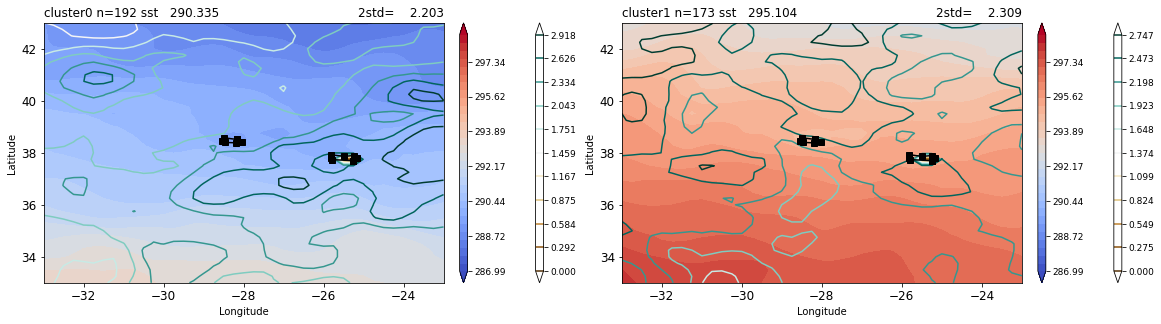

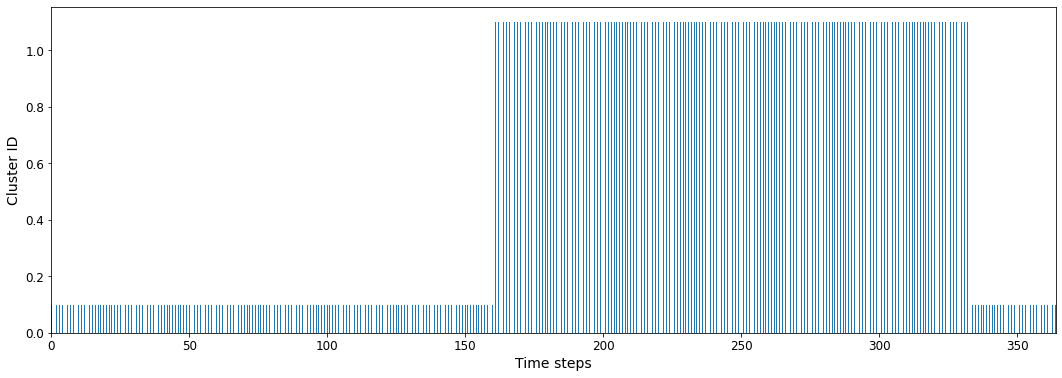

In [ ]:
visualization.visualization('./data/single_var_ERA5_meteo_sfc_2021_daily.nc','./data/tsne_sst.csv','./data/coast.txt',['sst'])

## - `Real` data with `kernelPCA` ( n_features=15  and n_cluster=4 )

In [129]:
print('RMSE is: ')
print( st_evaluation.st_rmse(data,kpca_labels))



RMSE is: 


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


       0      1      2      3
0  15.46  17.92  27.48  27.12
1  17.92  14.75   31.0  26.05
2  27.48   31.0  14.15  39.14
3  27.12  26.05  39.14  20.16


In [125]:
print('Spatial Correlation is: ')
print( st_evaluation.st_corr(data,kpca_labels))

Spatial Correlation is: 


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


          0         1         2         3
0      0.83  0.662869 -0.021777  0.261109
1  0.662869      0.87 -0.312206  0.557878
2 -0.021777 -0.312206      0.68 -0.536201
3  0.261109  0.557878 -0.536201      0.68


In [124]:
print("Silhouette Coefficient score is ", silhouette_score(tf_data, kpca_labels))

print("Davies-Bouldin score is ", davies_bouldin_score(tf_data, kpca_labels))

Silhouette Coefficient score is  0.29498057392165666
Davies-Bouldin score is  1.3947607572502754


In [ ]:
visualization.make_Csv_cluster(kpca_labels,'./data/kpca_real.csv')

total clusters:  4
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: The following kwargs were not used by contour: 'linewidth'


varid: t2m
var_range: [-0.08280723076385484, -0.07839707801928061]
varid: u10
var_range: [-15.129702662479593, 16.82725476413482]
varid: v10
var_range: [-14.294945017569995, 14.039669939743764]
varid: sshf
var_range: [-43.41541985801895, 175.22246693947238]
varid: sp
var_range: [985.3787786916515, 1035.1150602330122]


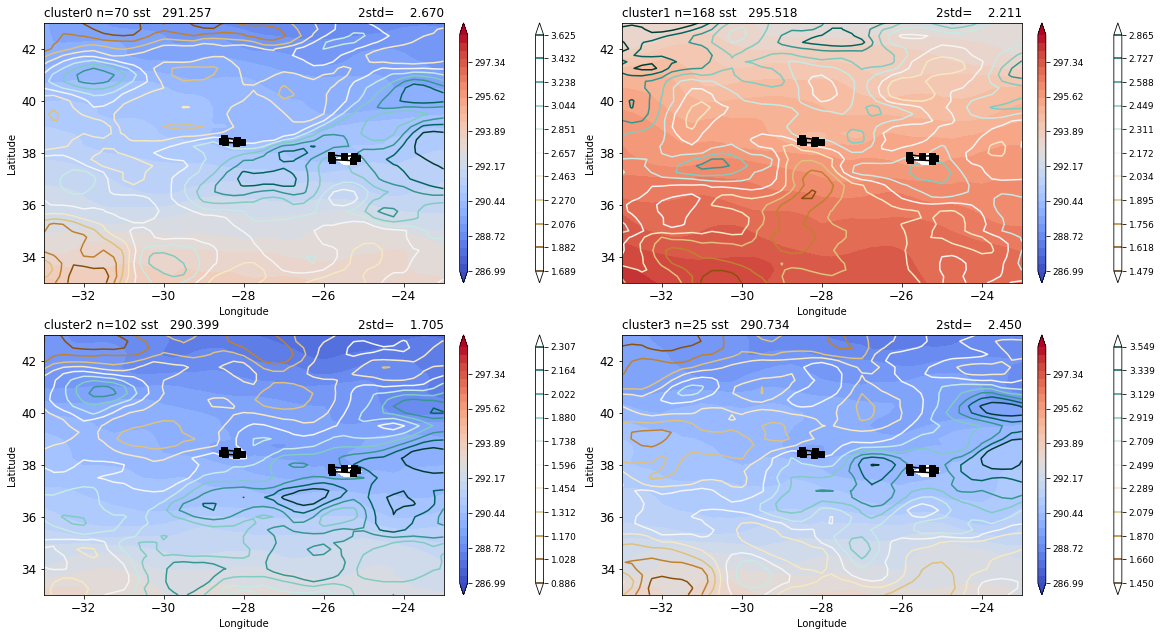

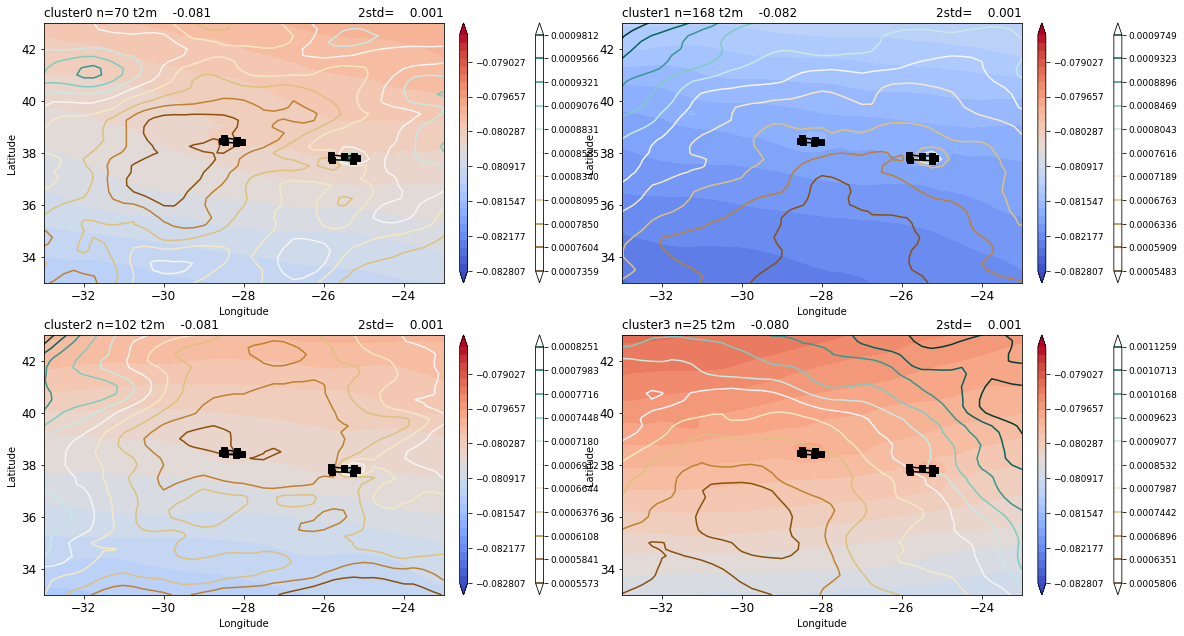

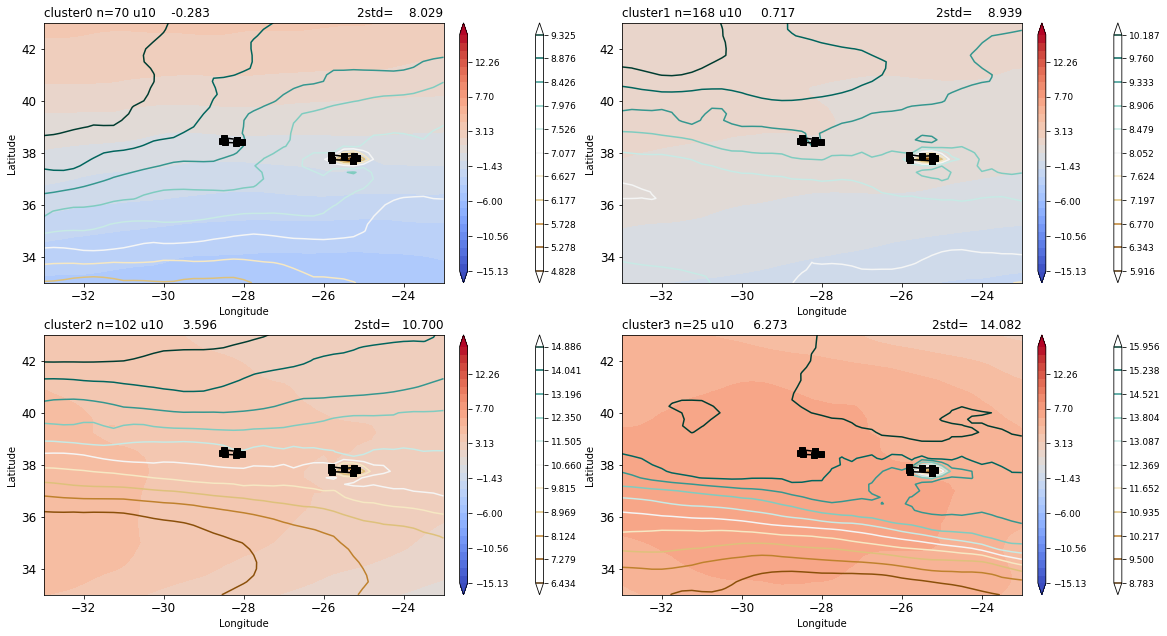

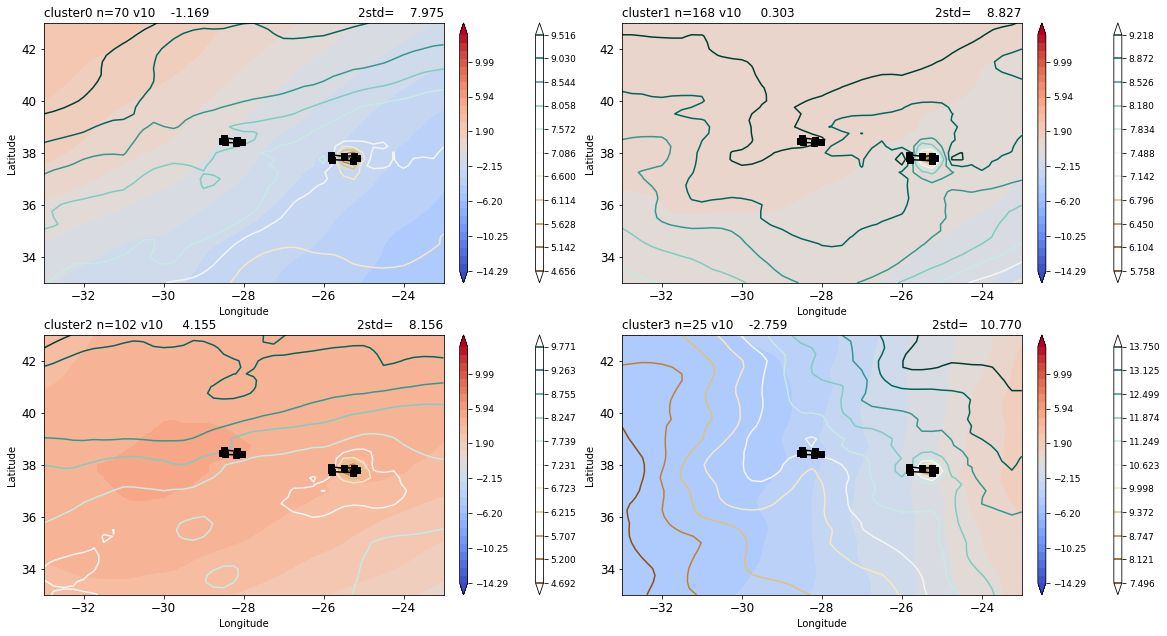

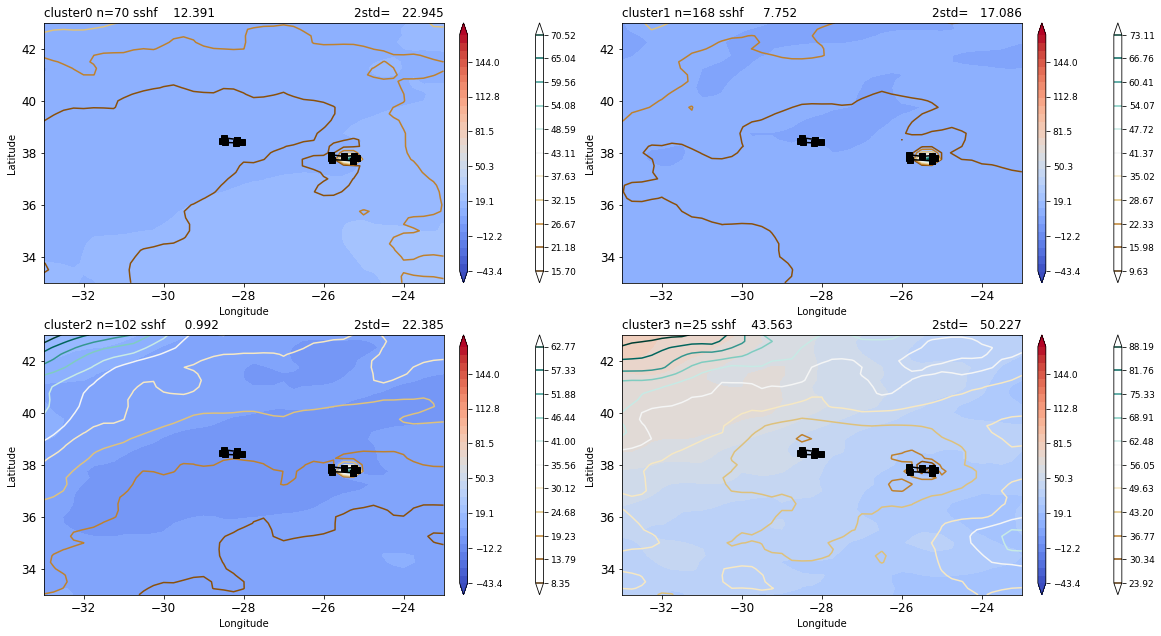

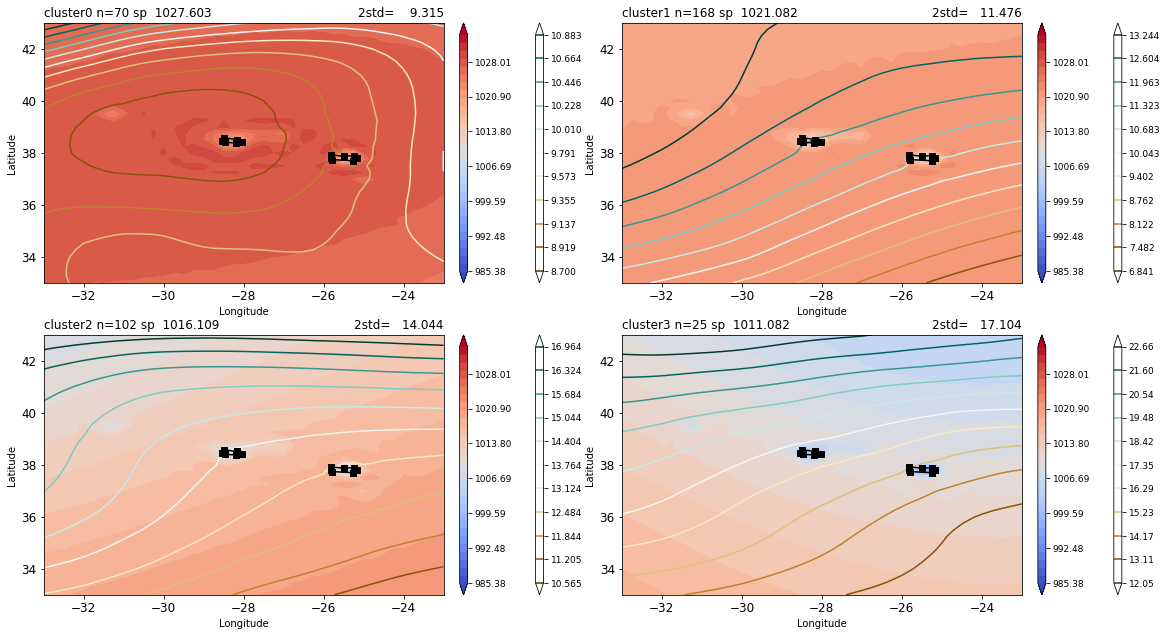

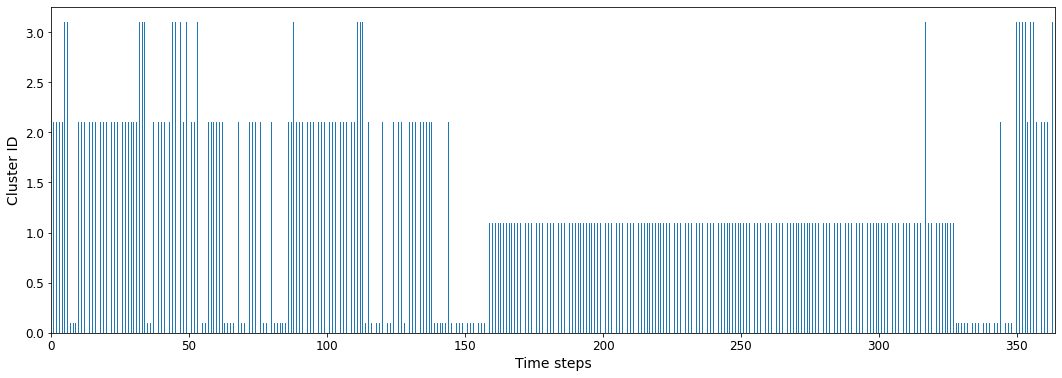

In [ ]:
visualization.visualization('./data/ERA5_meteo_sfc_2021_daily.nc','./data/kpca_real.csv','./data/coast.txt')

## - `Real` data with `t-SNE` ( n_features=2  and n_cluster=3 )

In [187]:
print('RMSE is: ')
print( st_evaluation.st_rmse(data,tsne_labels))


RMSE is: 


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


       0      1      2
0  17.47  18.53  21.18
1  18.53  18.18  33.56
2  21.18  33.56  13.17


In [188]:
print('Spatial Correlation is: ')
print( st_evaluation.st_corr(data,tsne_labels))

Spatial Correlation is: 


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


          0         1         2
0      0.69  0.551671  0.140156
1  0.551671       0.8 -0.418155
2  0.140156 -0.418155      0.72


In [186]:
print("Silhouette Coefficient score is ", silhouette_score(tf_data, tsne_labels))

print("Davies-Bouldin score is ", davies_bouldin_score(tf_data, tsne_labels))

Silhouette Coefficient score is  0.24741302532568013
Davies-Bouldin score is  1.6603308175260878


In [189]:
visualization.make_Csv_cluster(tsne_labels,'./data/tsne_real.csv')

total clusters:  3
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/content/multivariate-weather-data-clustering/mwdc/visualization/visualization.py:131: RuntimeWarning: Mean of empty slice
  var_mean_icluster = np.nanmean(var_icluster,axis=0)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/content/multivariate-weather-data-clustering/mwdc/visualization/visualization.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.subplot(panel)
/content/multivariate-weather-data-clustering/mwdc/visualization/visualization.py:74: UserWarning: The following kwargs were not used by contour: 'linewidth'
  p1=ax.contour(lon0,lat0,var,cmap=cmap0,le

varid: t2m
var_range: [-0.08280723076385484, -0.07839707801928061]
varid: u10
var_range: [-15.129702662479593, 16.82725476413482]
varid: v10
var_range: [-14.294945017569995, 14.039669939743764]
varid: sshf
var_range: [-43.41541985801895, 175.22246693947238]
varid: sp
var_range: [985.3787786916515, 1035.1150602330122]


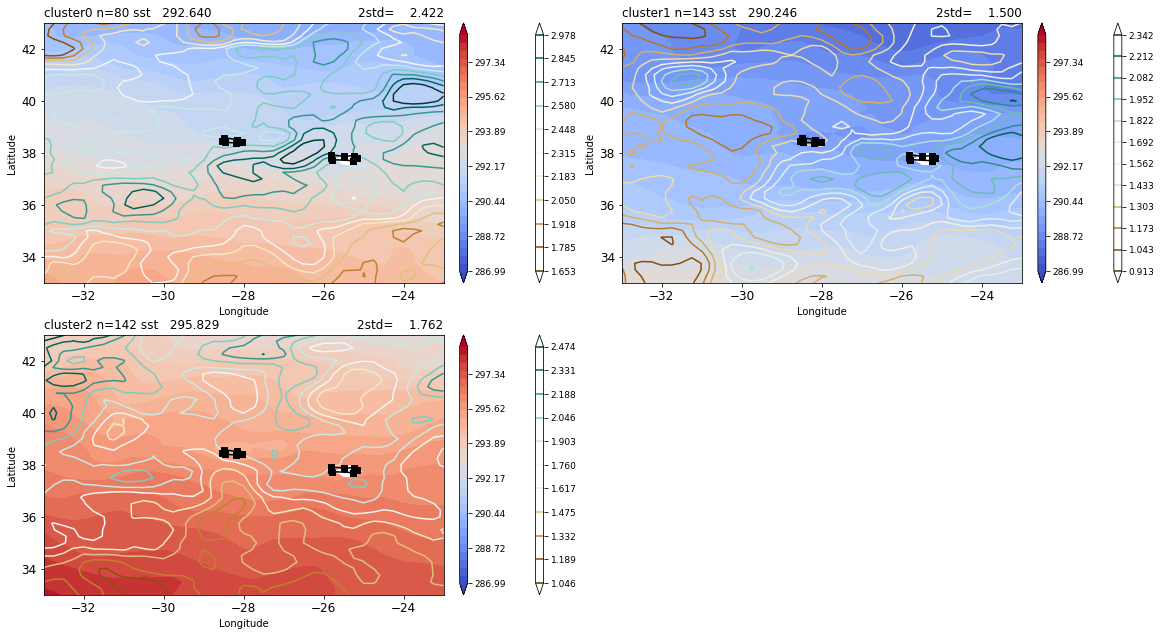

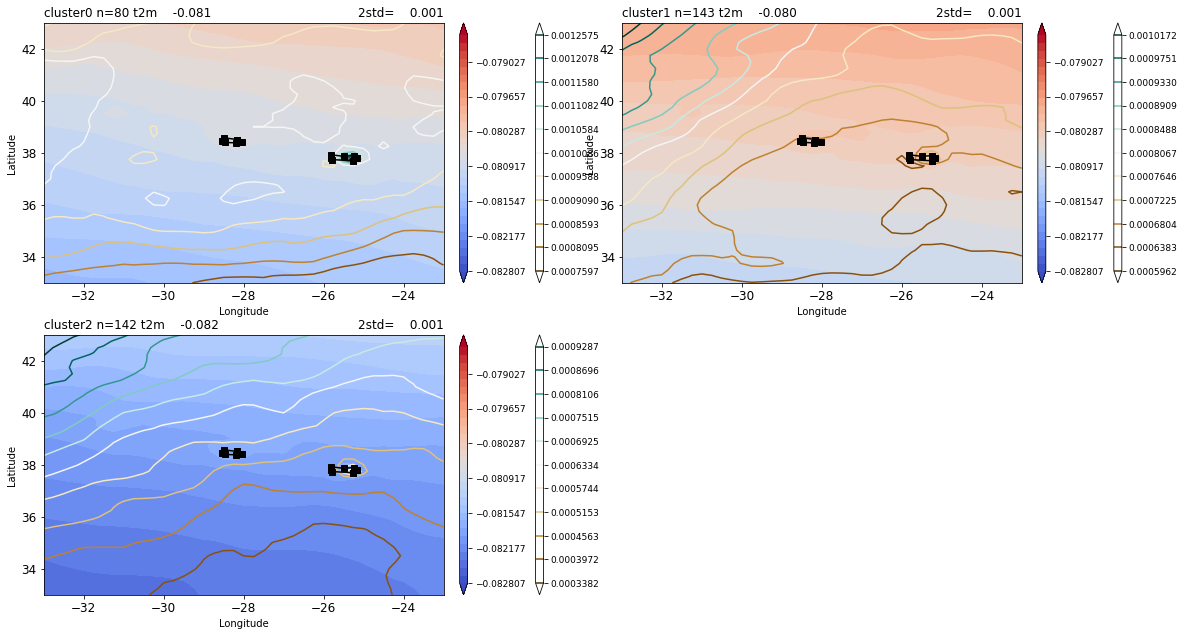

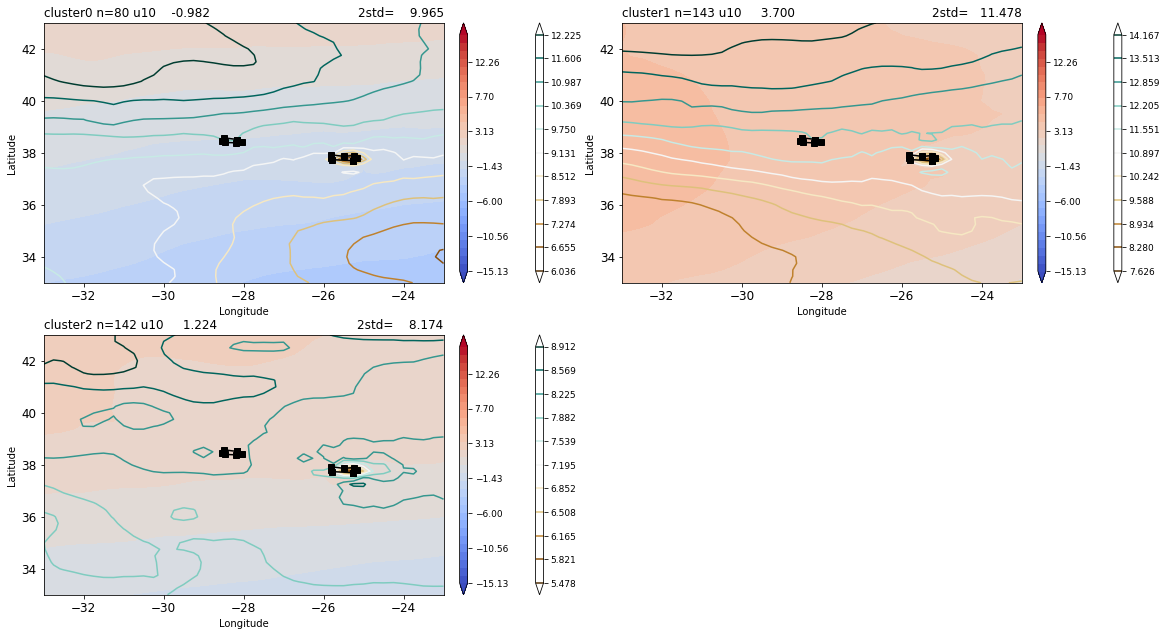

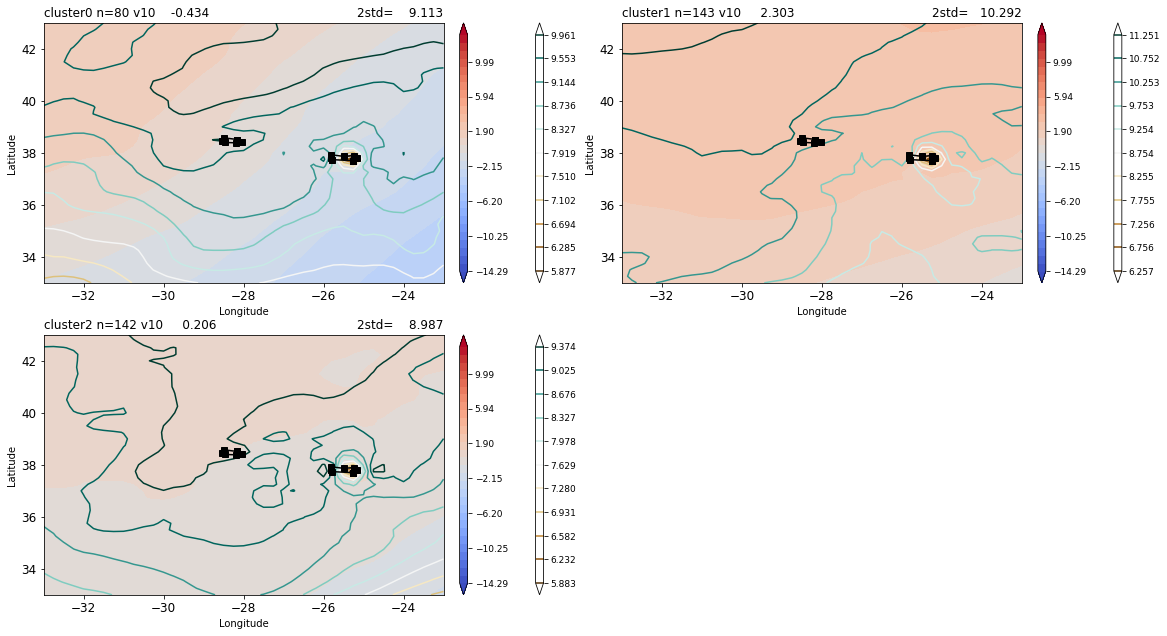

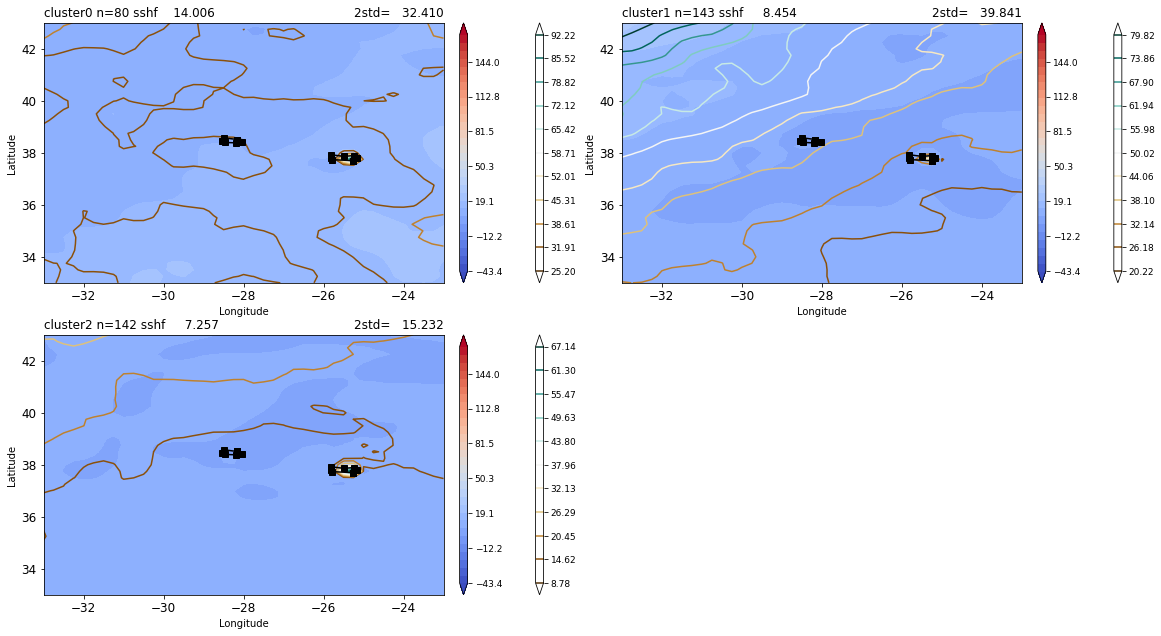

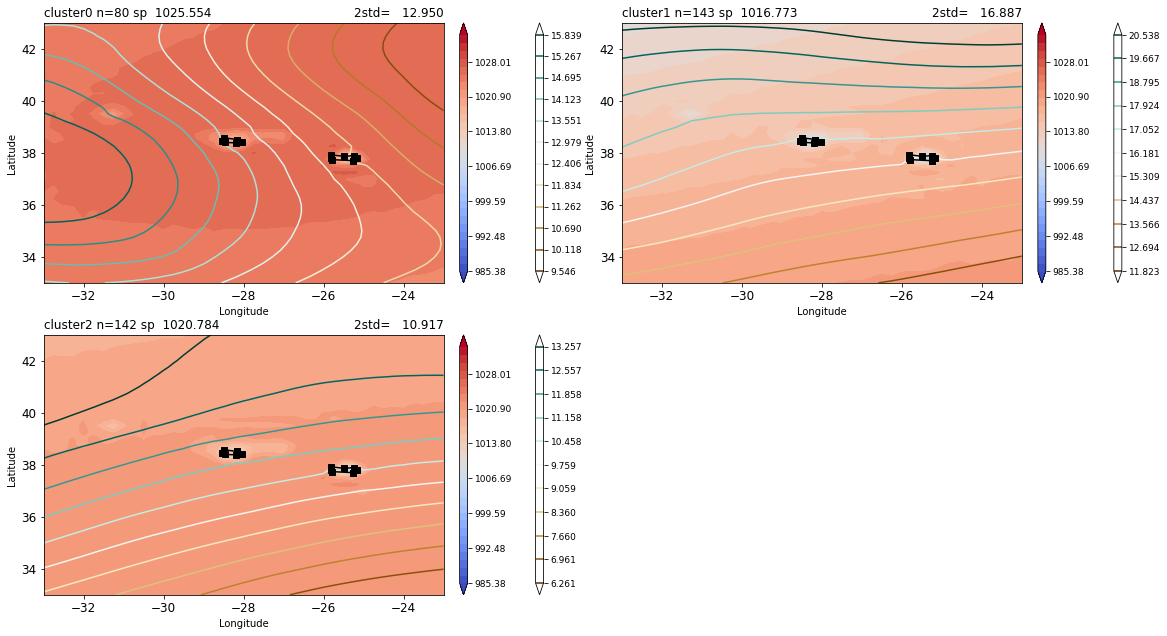

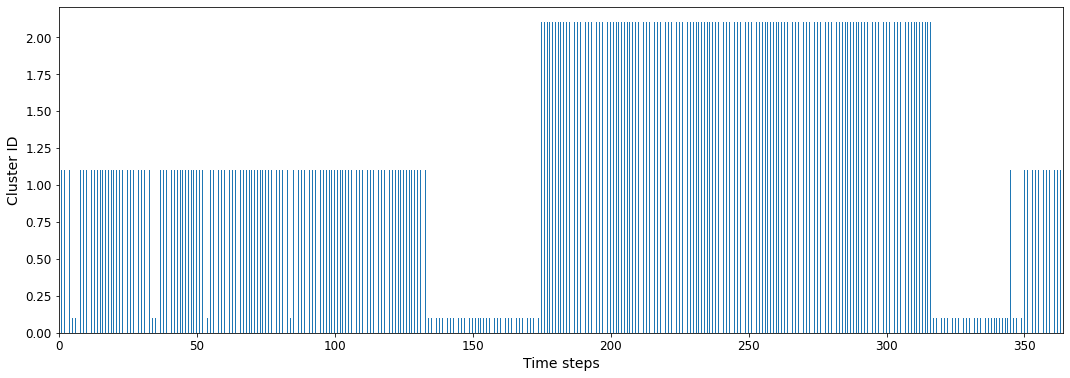

In [191]:
visualization.visualization('./data/ERA5_meteo_sfc_2021_daily.nc','./data/tsne_real.csv','./data/coast.txt')